<a href="https://colab.research.google.com/github/ifymifan/IOT-AI/blob/main/second_lab4_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 14.1 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sample 1:
  Waveform shape: torch.Size([1, 48000])
  Label: 3


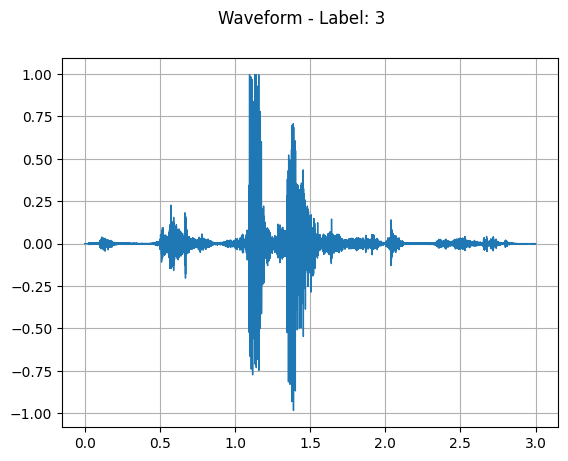

____________________________________________________________________________________________________
Sample 2:
  Waveform shape: torch.Size([1, 48000])
  Label: 3


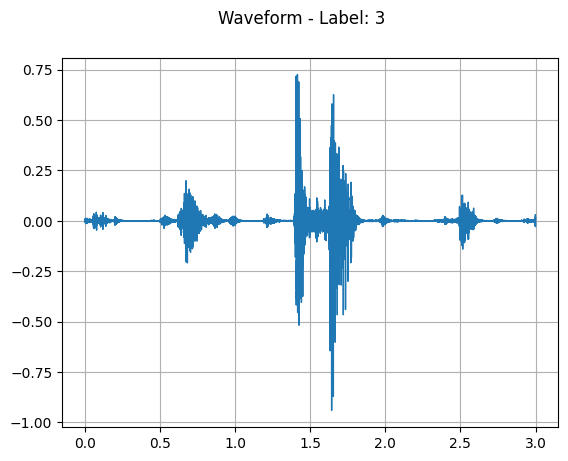

____________________________________________________________________________________________________
Sample 3:
  Waveform shape: torch.Size([1, 48000])
  Label: 3


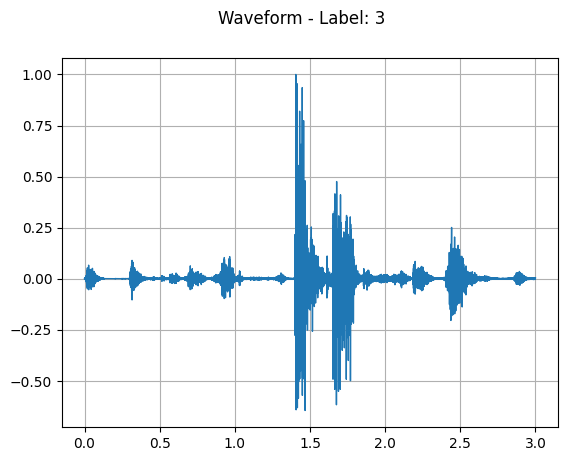

____________________________________________________________________________________________________
Sample 4:
  Waveform shape: torch.Size([1, 48000])
  Label: 3


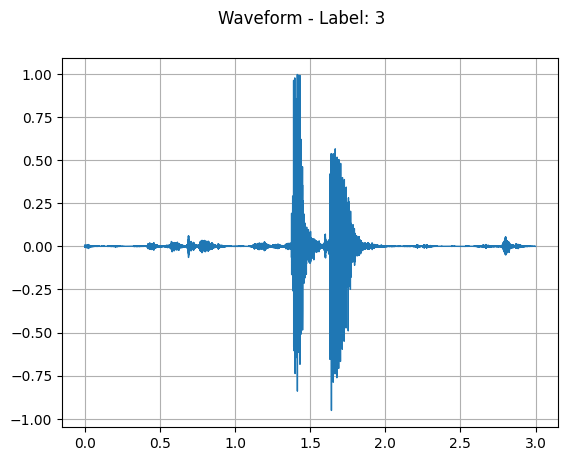

____________________________________________________________________________________________________
Sample 5:
  Waveform shape: torch.Size([1, 48000])
  Label: 3


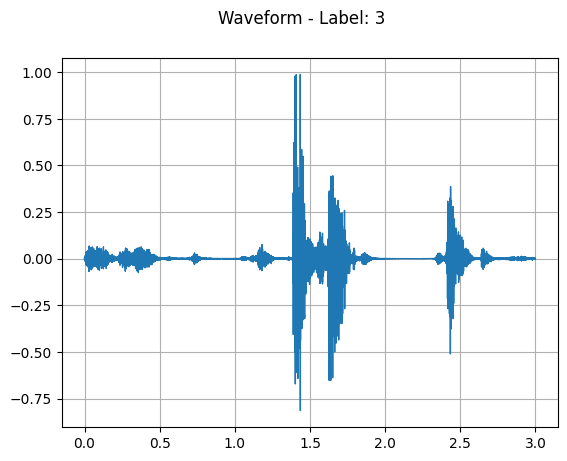

____________________________________________________________________________________________________


In [4]:
!pip install torchmetrics
!pip install torchaudio
!pip install torch
!pip install matplotlib
# Now all the libraries are installed.

from google.colab import drive
drive.mount('/content/drive')
import os
import json
import torchaudio
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt # Import matplotlib for plotting
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torchmetrics import Accuracy # This import should be valid after installing torchmetrics.

#            make class to load and hold data to keep it simple.   Help to structure from the old way.
class AudioDataset(Dataset):
    def __init__(self, data_root, folder_name):
        self.data_root = data_root
        self.folder_name = folder_name
        self.wav_files = []
        self.labels = []
        self._load_data()
        self.label_mapping = {label: i for i, label in enumerate(set(self.labels))}

    def _load_data(self):
        # Load info.labels file
        with open(os.path.join(self.data_root, self.folder_name, 'info.labels'), 'r') as f:
            label_data = json.load(f)

        # Get filenames and labels and load them into wav file and labels.
        for file_info in label_data['files']:
            wav_file_path = os.path.join(self.data_root, self.folder_name, file_info['path'])
            if os.path.exists(wav_file_path):
                self.wav_files.append(wav_file_path)
                self.labels.append(file_info['label']['label'])
            else:
                print(f"Warning: File not found: {wav_file_path}")

    def __len__(self):
        return len(self.wav_files)

    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.wav_files[idx])
        # Convert label to numerical index using label_mapping
        label_index = self.label_mapping[self.labels[idx]]
        return waveform, label_index

# Set data paths
data_root ='/content/drive/MyDrive/Second_lab4'

# Create dataset instances
train_dataset = AudioDataset(data_root, 'training')
test_dataset = AudioDataset(data_root, 'testing')

def plot_waveform(waveform, sample_rate, title="Waveform"):
    """Plots the waveform."""
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
    figure.suptitle(title)
    plt.show(block=False)

# check that data has been load into train dataset correctly
for i in range(5):
    waveform, label = train_dataset[i]
    print(f"Sample {i + 1}:")
    print(f"  Waveform shape: {waveform.shape}")
    print(f"  Label: {label}")
    plot_waveform(waveform, sample_rate=16000, title=f"Waveform - Label: {label}")  # sample rate is 16000 (Selected in edgeImpuls as part of sampling)
    print("_" * 100)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

all_labels = set(train_dataset.labels)
label2num = {label: num for num, label in enumerate(all_labels)}
print(label2num)

def collate_fn(batch):
  data = [b[0][0] for b in batch]
  data = pad_sequence(data, batch_first=True)
  labels = torch.LongTensor([label2num[b[2]] for b in batch])
  return data, labels


{'Cherry': 0, 'Orange': 1, 'Unknown': 2, 'Apple': 3}


In [6]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x.squeeze(1)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
model = M5(n_input=1, n_output=4)
model.to(device)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=4, bias=True)
)

In [10]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

In [11]:
num_params(model)

0.0249

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
num_cls = 4

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass',num_classes=4).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [15]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy().to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

In [16]:
num_epochs = 50
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

Epoch 49: 100%|██████████| 215/215 [00:08<00:00, 24.27batch/s, accuracy=28.4, loss=1.57]
